<a href="https://colab.research.google.com/github/madhupriya24/zeroday_attackdetections/blob/main/UNSW_nb15ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Download latest version
path = kagglehub.dataset_download("dhoogla/unswnb15")
print("Path to dataset files:", path)

# Define paths
train_path = '/root/.cache/kagglehub/datasets/dhoogla/unswnb15/versions/5/UNSW_NB15_training-set.parquet'
test_path = '/root/.cache/kagglehub/datasets/dhoogla/unswnb15/versions/5/UNSW_NB15_testing-set.parquet'

# Load datasets
df1 = pd.read_parquet(train_path)
df2 = pd.read_parquet(test_path)

# Combine and shuffle
final_df = pd.concat([df1, df2])
final_df = shuffle(final_df)

# Remove duplicates
final_df.drop_duplicates(keep='first', inplace=True)

# Handle missing values
final_df.dropna(inplace=True)  # Drop rows with missing values

# Encode attack categories
def encode_attack_category(df, column="attack_cat"):
    attack_mapping = {
        'Normal': 0, 'Generic': 1, 'Exploits': 2, 'Fuzzers': 3, 'DoS': 4,
        'Reconnaissance': 5, 'Analysis': 6, 'Backdoor': 7, 'Shellcode': 8, 'Worms': 9
    }
    df[column] = df[column].map(attack_mapping)
    return df

final_df = encode_attack_category(final_df)

# Split dataset: Zero-day (Reconnaissance & Analysis) vs. Other Attacks
zero_day_df = final_df[final_df['attack_cat'].isin([5, 6])]
df = final_df[~final_df['attack_cat'].isin([5, 6])]

print("Zero-day dataset shape:", zero_day_df.shape)
print("Other attacks dataset shape before SMOTE:", df.shape)

# Outlier Removal using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Select only numerical columns for outlier removal
numeric_columns = df.select_dtypes(include=['number']).columns
df = remove_outliers(df, numeric_columns)

Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/unswnb15/versions/5
Zero-day dataset shape: (9454, 36)
Other attacks dataset shape before SMOTE: (135768, 36)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14159 entries, 113911 to 80473
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                14159 non-null  float32 
 1   proto              14159 non-null  object  
 2   service            14159 non-null  category
 3   state              14159 non-null  object  
 4   spkts              14159 non-null  int16   
 5   dpkts              14159 non-null  int16   
 6   sbytes             14159 non-null  int32   
 7   dbytes             14159 non-null  int32   
 8   rate               14159 non-null  float32 
 9   sload              14159 non-null  float32 
 10  dload              14159 non-null  float32 
 11  sloss              14159 non-null  int16   
 12  dloss              14159 non-null  int16   
 13  sinpkt             14159 non-null  float32 
 14  dinpkt             14159 non-null  float32 
 15  sjit               14159 non-null  float32 
 16  djit

<ipython-input-12-cd1dc5d103bc>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values[:22], y=feature_importances.index[:22], palette="viridis")


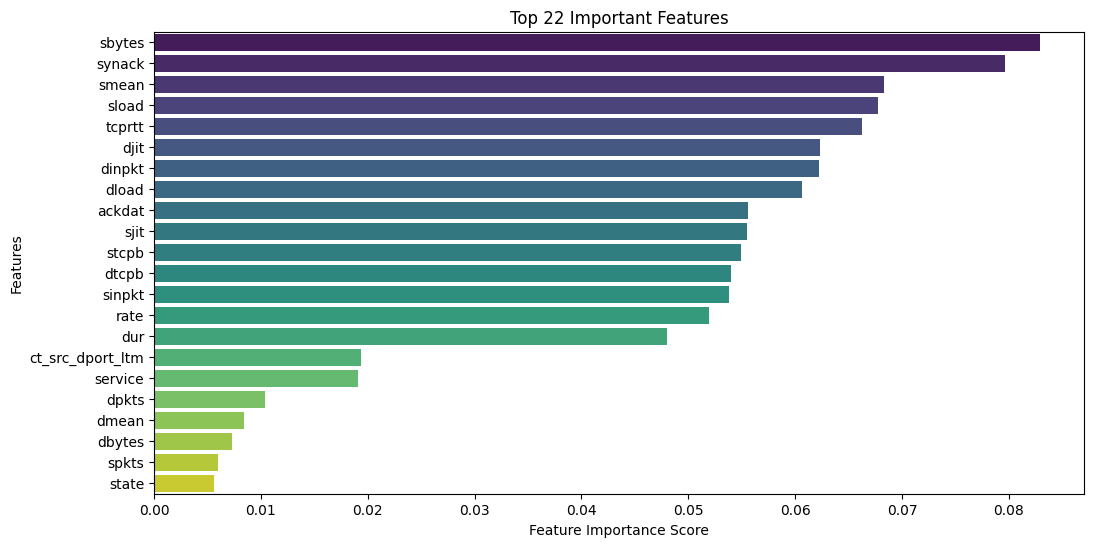

Selected Features: ['dur', 'sbytes', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat', 'smean']
Class Distribution Before SMOTE:
 label
0    6050
1    5277
Name: count, dtype: int64
Class Distribution After SMOTE:
 label
0    6050
1    6050
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 4: Feature Selection (Using RandomForest)
def feature_selection(df, target_column="label"):
    X = df.drop(columns=[target_column, 'attack_cat'])
    y = df[target_column]

    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object','category']).columns

    # Apply Label Encoding to categorical features
    for col in categorical_cols:
        X[col] = LabelEncoder().fit_transform(X[col])

    # Train RandomForest to get feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importance
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    # Plot Top 22 Important Features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_importances.values[:22], y=feature_importances.index[:22], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Top 22 Important Features")
    plt.show()

    # Select important features
    selector = SelectFromModel(rf, threshold="mean", prefit=True)
    selected_features = X.columns[(selector.get_support())]

    print("Selected Features:", selected_features.tolist())
    return df[selected_features.tolist() + [target_column]]

# Apply feature selection
df = feature_selection(df)

# Train-Test Split
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

# Check Class Distribution Before SMOTE
print("Class Distribution Before SMOTE:\n", pd.Series(y_train).value_counts())

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Auto balances all classes
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check Class Distribution After SMOTE
print("Class Distribution After SMOTE:\n", pd.Series(y_train).value_counts())

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to categorical (for deep learning models)
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Reshape input for CNN/GRU/BiLSTM models (Add a 3rd dimension for Conv1D)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GRU, LSTM, Bidirectional, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

cnn_gru = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn_gru.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
cnn_gru.fit(X_train_cnn, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test_cat))

# Evaluate CNN-GRU
cnn_gru_pred = cnn_gru.predict(X_test_cnn).argmax(axis=1)
print("CNN-GRU Accuracy:", accuracy_score(y_test, cnn_gru_pred))
print(classification_report(y_test, cnn_gru_pred))

Random Forest Accuracy: 0.6987994350282486
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1521
           1       0.69      0.64      0.66      1311

    accuracy                           0.70      2832
   macro avg       0.70      0.70      0.70      2832
weighted avg       0.70      0.70      0.70      2832



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:50:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7100988700564972
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1521
           1       0.70      0.66      0.68      1311

    accuracy                           0.71      2832
   macro avg       0.71      0.71      0.71      2832
weighted avg       0.71      0.71      0.71      2832

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.5355 - loss: 0.6910 - val_accuracy: 0.5939 - val_loss: 0.6866
Epoch 2/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5777 - loss: 0.6802 - val_accuracy: 0.6225 - val_loss: 0.6556
Epoch 3/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6162 - loss: 0.6576 - val_accuracy: 0.6487 - val_loss: 0.6365
Epoch 4/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6295 - loss: 0.6437 - val_accuracy: 0.6349 - val_loss: 0.6405
Epoch 5/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6381 - loss: 0.6416 - val_accuracy: 0.6532 - val_loss: 0.6233
Epoch 6/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6434 - loss: 0.6357 - val_accuracy: 0.6568 - val_loss: 0.6314
Epoch 7/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6314 - loss: 0.6317 - val_accuracy: 0.6561 - val_loss: 0.6183
Epoch 8/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6442 - loss: 0.6315 - val_accuracy: 0

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        q, v = inputs, inputs
        attention_scores = tf.matmul(q, v, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, v)

cnn_bilstm_attention = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Bidirectional(LSTM(64, return_sequences=True)),
    AttentionLayer(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn_bilstm_attention.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
cnn_bilstm_attention.fit(X_train_cnn, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_cat))

# Evaluate CNN-BiLSTM-Attention
cnn_bilstm_pred = cnn_bilstm_attention.predict(X_test_cnn).argmax(axis=1)
print("CNN-BiLSTM-Attention Accuracy:", accuracy_score(y_test, cnn_bilstm_pred))
print(classification_report(y_test, cnn_bilstm_pred))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


912/912 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.7631 - loss: 0.5307 - val_accuracy: 0.8446 - val_loss: 0.3915
Epoch 2/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.8382 - loss: 0.3583 - val_accuracy: 0.8746 - val_loss: 0.3032
Epoch 3/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8529 - loss: 0.3087 - val_accuracy: 0.8751 - val_loss: 0.3006
Epoch 4/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8683 - loss: 0.2885 - val_accuracy: 0.8783 - val_loss: 0.2715
Epoch 5/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.8698 - loss: 0.2755 - val_accuracy: 0.8678 - val_loss: 0.2825
Epoch 6/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.8716 - loss: 0.2697 - val_accuracy: 0.8926 - val_loss: 0.2398
Epoch 7/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.8777 - loss: 0.2542 - val_accuracy: 0.8858 - val_loss: 0.2603
Epoch 8/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.8771 - loss: 0.2502 - val_accurac

In [ ]:
selected_features = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'PSH Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']
zero_day_df = zero_day_df[selected_features + ['Label']]

In [ ]:
X_zero = zero_day_df.drop(['Label'],axis=1)
y_zero = zero_day_df['Label']
X_zero = np.array(X_zero)
y_zero = np.array(y_zero)

# Convert labels to categorical for deep learning models
y_zero_cat = to_categorical(y_zero, num_classes=num_classes)

# Reshape for CNN/GRU/BiLSTM models
X_zero_cnn = X_zero.reshape(X_zero.shape[0], X_zero.shape[1], 1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score # Import necessary functions
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, prec, rec, f1

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf, X_zero, y_zero)

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb, X_zero, y_zero)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_zero_cnn, y_zero)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention, X_zero_cnn, y_zero)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
import pandas as pd

# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.15       0.22    0.15      0.10
1               XGBoost      0.11       0.25    0.11      0.19
2               CNN-GRU      0.22       0.45    0.22      0.36
3  CNN-BiLSTM-Attention      0.72       0.78    0.72      0.83


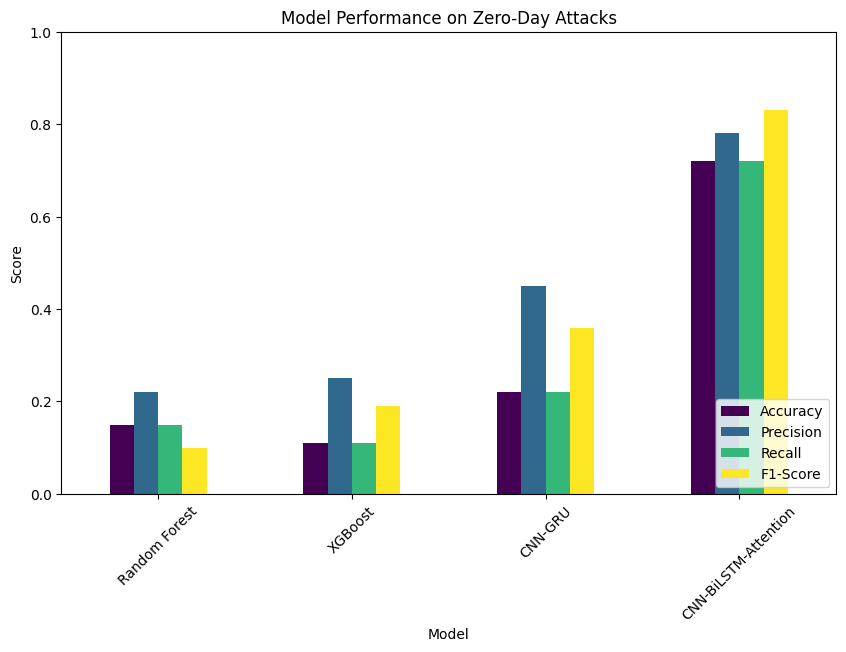

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.stats import entropy

# -------------------------------
# 1️Prepare the Data
# -------------------------------

# Select only attack samples (excluding zero-day data)
known_attack_df = df[df['label'] != 0].drop(columns=['attack_cat','label'])

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
known_attack_scaled = scaler.fit_transform(known_attack_df)

# Dimensions
latent_dim = 100  # Noise vector size
data_dim = known_attack_scaled.shape[1]

# -------------------
# 🛠 WGAN-GP Components
# -------------------

#  **Generator**
def build_generator(input_dim, output_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(0.2),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(0.2),
        BatchNormalization(),
        Dense(1024),
        LeakyReLU(0.2),
        BatchNormalization(),
        Dense(output_dim, activation='tanh')
    ])
    return model

#  **Critic (Discriminator)**
def build_critic(input_dim):
    model = Sequential([
        Dense(1024, input_dim=input_dim),
        LeakyReLU(0.2),
        Dense(512),
        LeakyReLU(0.2),
        Dense(256),
        LeakyReLU(0.2),
        Dense(1)  # Wasserstein output
    ])
    return model

# -------------------
#  Training Setup
# -------------------

# Load real attack samples (preprocessed)
# Assign known_attack_scaled to X_train
X_train = known_attack_scaled # Shape: (num_samples, num_features)
latent_dim = 200  # Increase latent space for better feature diversity
batch_size = 64
epochs = 500
lambda_gp = 15  # Increase gradient penalty for stability

# Instantiate models
generator = build_generator(latent_dim, X_train.shape[1])
critic = build_critic(X_train.shape[1])

# Optimizers
critic_optimizer = Adam(0.0002, beta_1=0.5, beta_2=0.9)
generator_optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)

# -------------------
#  Gradient Penalty Function
# -------------------
def compute_gradient_penalty(real_samples, fake_samples):
    alpha = tf.random.uniform([real_samples.shape[0], 1], 0.0, 1.0)
    interpolated_samples = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as tape:
        tape.watch(interpolated_samples)
        pred = critic(interpolated_samples, training=True)
    grads = tape.gradient(pred, interpolated_samples)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-10)
    gradient_penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return gradient_penalty

# -------------------
#  Training Loop
# -------------------
for epoch in range(epochs):

    for _ in range(5):  # Train Critic 5x per Generator update
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        with tf.GradientTape() as tape:
            real_pred = critic(real_samples, training=True)
            fake_pred = critic(fake_samples, training=True)
            gp = compute_gradient_penalty(real_samples, fake_samples)
            critic_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + lambda_gp * gp

        critic_gradients = tape.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    with tf.GradientTape() as tape:
        fake_samples = generator(noise, training=True)
        fake_pred = critic(fake_samples, training=True)
        generator_loss = -tf.reduce_mean(fake_pred)

    generator_gradients = tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    # Log & Plot
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Critic Loss={critic_loss.numpy()}, Generator Loss={generator_loss.numpy()}")

# -------------------
# Generate Synthetic Attacks
# -------------------
# Generate synthetic attacks
num_samples = 1000
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_attacks = generator.predict(noise)

# Reverse MinMax Scaling
synthetic_attacks = scaler.inverse_transform(synthetic_attacks)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_attacks, columns=known_attack_df.columns)

# Save synthetic data
synthetic_df.to_csv('synthetic_zero_day_attacks.csv', index=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 0: Critic Loss=4.669722080230713, Generator Loss=0.030685799196362495
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━

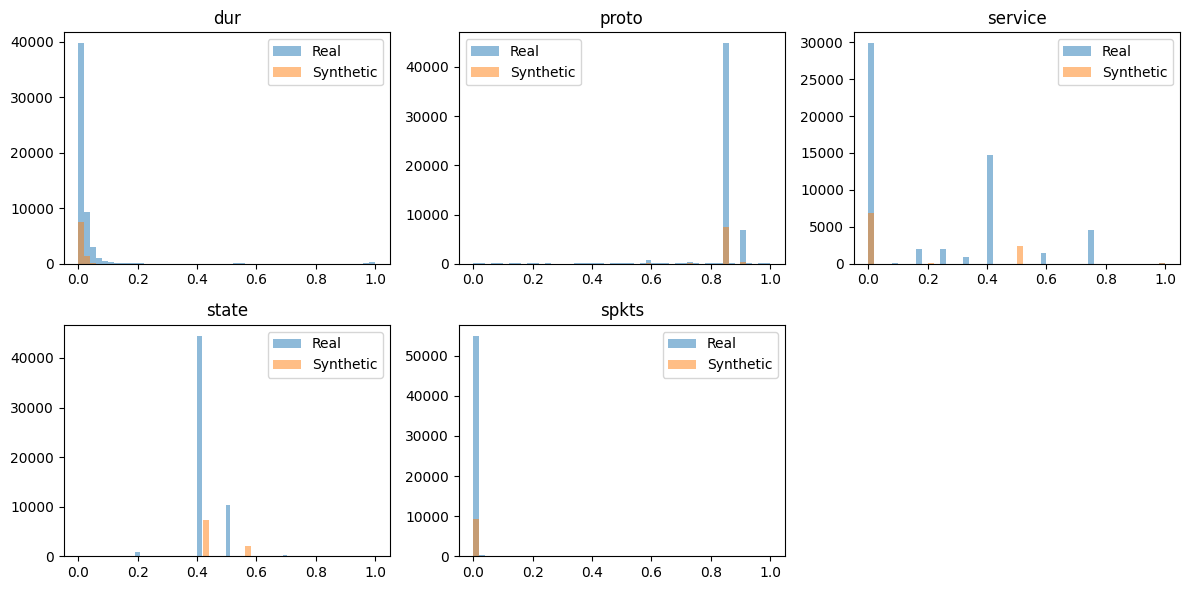

KL Divergence per feature:
is_sm_ips_ports       0.000000
dwin                  0.001779
swin                  0.001782
stcpb                 0.003873
dtcpb                 0.004265
rate                  0.010223
djit                  0.034957
response_body_len     0.035635
spkts                 0.040557
sbytes                0.043966
synack                0.052663
sinpkt                0.054156
dinpkt                0.057890
dbytes                0.085873
dloss                 0.088812
dur                   0.089364
sjit                  0.099083
proto                 0.116648
dpkts                 0.135910
sload                 0.183775
trans_depth           0.269310
tcprtt                0.890292
dload                 1.276593
ackdat                1.317732
ct_flw_http_mthd      1.639536
sloss                 1.708082
ct_src_dport_ltm      2.057961
ct_dst_sport_ltm      2.506300
dmean                 3.130001
smean                 4.113657
service              11.323705
state       

In [ ]:
# -------------------------------
# Evaluate Generated Attacks
# -------------------------------

# Compare feature distributions (Real vs. Synthetic)
plt.figure(figsize=(12, 6))
for i, col in enumerate(synthetic_df.columns[:5]):  # Plot first 5 features
    plt.subplot(2, 3, i + 1)
    plt.hist(known_attack_df[col], bins=50, alpha=0.5, label="Real")
    plt.hist(X_zero[col], bins=50, alpha=0.5, label="Synthetic")
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

# Compute KL divergence
kl_divergence = {}
for col in known_attack_df.columns:
    real_dist = np.histogram(known_attack_df[col], bins=50, density=True)[0]
    synthetic_dist = np.histogram(X_zero[col], bins=50, density=True)[0]
    kl_divergence[col] = entropy(real_dist + 1e-10, synthetic_dist + 1e-10)  # Avoid log(0)

print("KL Divergence per feature:")
print(pd.Series(kl_divergence).sort_values())

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Prepare synthetic data for CNN/GRU/BiLSTM models
X_synthetic_cnn = np.array(synthetic_df.drop('Label_New', axis=1)).reshape(synthetic_df.shape[0], synthetic_df.shape[1]-1, 1)
y_synthetic_cat = to_categorical(synthetic_df['Label_New'], num_classes=num_classes)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_synthetic_cnn, y_synthetic_cat)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention,   X_synthetic_cnn, y_synthetic_cat)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
#synthetic_data
import pandas as pd

# Create DataFrame for easy comparison
# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

# Format to two decimal points
results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.14       0.29    0.14      0.25
1               XGBoost      0.12       0.22    0.12      0.22
2               CNN-GRU      0.59       0.68    0.59      0.74
3  CNN-BiLSTM-Attention      0.72       0.78    0.72      0.83


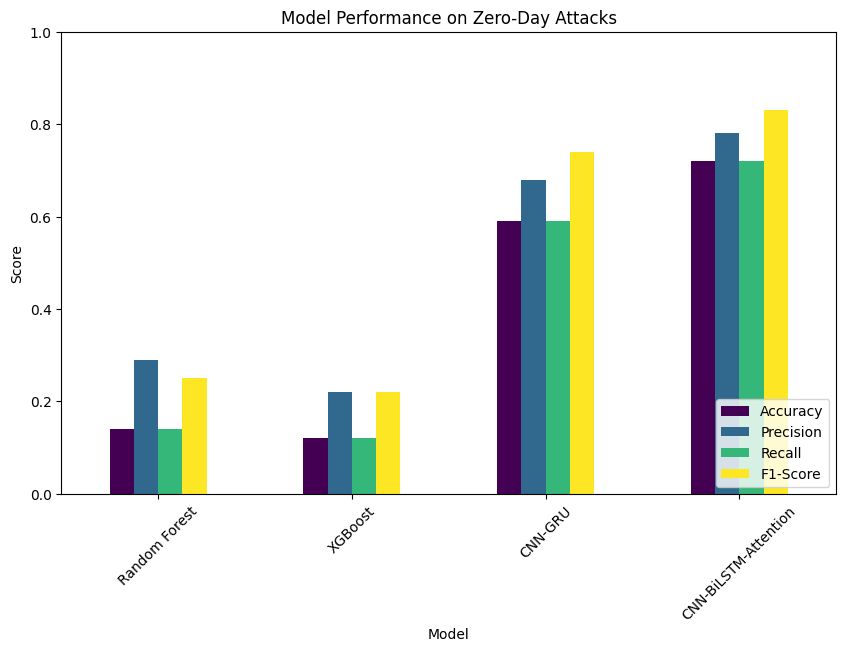

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, GRU, Flatten, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib


# ---------- Step 1: Load & Merge GAN-Generated Data with Actual Dataset ----------
gan_df = pd.read_csv("/content/synthetic_zero_day_attacks.csv")  # Load GAN-generated attacks
gan_df['label'] = 1

# Merge datasets
merged_df = pd.concat([df, gan_df], ignore_index=True)
X = merged_df.drop(columns=['label'])
y = merged_df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- CNN-GRU Model ----
cnn_gru_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(y.unique()), activation='softmax')
])

cnn_gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape input for CNN-GRU
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1) # Convert X_train to a NumPy array using .values before reshaping
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1) # Convert X_test to a NumPy array using .values before reshaping

# Train CNN-GRU
cnn_gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Save CNN-GRU model
cnn_gru_model.save('cnn_gru_model.h5')

# ---- Random Forest Model ----
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'random_forest.pkl')

# ---- XGBoost Model ----
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'xgboost.pkl')

# ---- Performance Evaluation ----
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, prec, rec, f1

# Evaluate all models
models = {'CNN-GRU': cnn_gru_model, 'Random Forest': rf_model, 'XGBoost': xgb_model}
for name, model in models.items():
    acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

print("Model training and evaluation complete!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 158s 44ms/step - accuracy: 0.7746 - loss: 0.4168 - val_accuracy: 0.8537 - val_loss: 0.2817
Epoch 2/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 150s 44ms/step - accuracy: 0.8627 - loss: 0.2623 - val_accuracy: 0.8643 - val_loss: 0.2464
Epoch 3/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 202s 44ms/step - accuracy: 0.8700 - loss: 0.2409 - val_accuracy: 0.8754 - val_loss: 0.2357
Epoch 4/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 149s 44ms/step - accuracy: 0.8702 - loss: 0.2368 - val_accuracy: 0.8705 - val_loss: 0.2399
Epoch 5/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 203s 44ms/step - accuracy: 0.8734 - loss: 0.2318 - val_accuracy: 0.8758 - val_loss: 0.2339
Epoch 6/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 151s 44ms/step - accuracy: 0.8759 - loss: 0.2292 - val_accuracy: 0.8697 - val_loss: 0.2512
Epoch 7/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 199s 43ms/step - accuracy: 0.8817 - loss: 0.2237 - val_accuracy: 0.8762 - val_loss: 0.2265
Epoch 8/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 203s 44ms/step - accuracy: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0049 - val_loss: 5.9859e-04
Epoch 2/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.3503e-04 - val_loss: 5.4173e-04
Epoch 3/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.0950e-04 - val_loss: 5.3001e-04
Epoch 4/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 4.0841e-04 - val_loss: 4.3899e-04
Epoch 5/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.9570e-04 - val_loss: 3.6500e-04
Epoch 6/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.8184e-04 - val_loss: 3.7129e-04
Epoch 7/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3.6950e-04 - val_loss: 3.4464e-04
Epoch 8/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.4909e-04 - val_loss: 0.0010
Epoch 9/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.7037e-04 - val_loss: 3.7468e-04
Epoch 10/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 3.7898e-04 - val_loss: 3.2108e-04


855/855 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
CNN-GRU - Accuracy: 0.8676, Precision: 0.8688, Recall: 0.8676, F1-score: 0.8679
Random Forest - Accuracy: 0.9017, Precision: 0.9015, Recall: 0.9017, F1-score: 0.9015
XGBoost - Accuracy: 0.9054, Precision: 0.9052, Recall: 0.9054, F1-score: 0.9052
Model training and evaluation complete!


In [ ]:
from tensorflow.keras.layers import Bidirectional, Attention , MaxPooling1D

def build_cnn_bilstm_attention(input_shape):
    inputs = Input(shape=input_shape)

    # CNN Layers
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # BiLSTM Layers
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Attention Mechanism
    attn = Attention()([x, x])  # Self-attention

    # Apply Global Average Pooling to get a fixed-size output
    x = tf.keras.layers.GlobalAveragePooling1D()(attn)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)  # For binary classification

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate model
model = build_cnn_bilstm_attention(input_shape=(X_train.shape[1], 1))

# ---------- Train Model ----------
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 90s - loss: 0.1968 - accuracy: 0.9163 - val_loss: 0.2429 - val_accuracy: 0.9080
Epoch 2/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 85s - loss: 0.1523 - accuracy: 0.9342 - val_loss: 0.2580 - val_accuracy: 0.9118
Epoch 3/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 83s - loss: 0.1452 - accuracy: 0.9358 - val_loss: 0.2460 - val_accuracy: 0.9118
Epoch 4/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 82s - loss: 0.1393 - accuracy: 0.9362 - val_loss: 0.3066 - val_accuracy: 0.9103
Epoch 5/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 82s - loss: 0.1339 - accuracy: 0.9371 - val_loss: 0.3333 - val_accuracy: 0.9137
Epoch 6/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 81s - loss: 0.1311 - accuracy: 0.9377 - val_loss: 0.3731 - val_accuracy: 0.9136
Epoch 7/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 81s - loss: 0.1290 - accuracy: 0.9379 - val_loss: 0.3555 - val_accuracy: 0.9126
Epoch 8/10
3395/3395 ━━━━━━━━━━━━━━━━━━━━ 80s - loss: 0.1280 - accuracy: 0.9384 - val_loss: 0.3925 - val_accuracy: 0.9139
Epoch 9/10
3395/3395 ━━━

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf, X_zero, y_zero)

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb, X_zero, y_zero)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_zero_cnn, y_zero)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention, X_zero_cnn, y_zero)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
import pandas as pd

# Create DataFrame for easy comparison
# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.60       0.65    0.60      0.75
1               XGBoost      0.78       0.81    0.78      0.86
2               CNN-GRU      0.88       0.89    0.88      0.92
3  CNN-BiLSTM-Attention      0.97       0.95    0.97      0.98


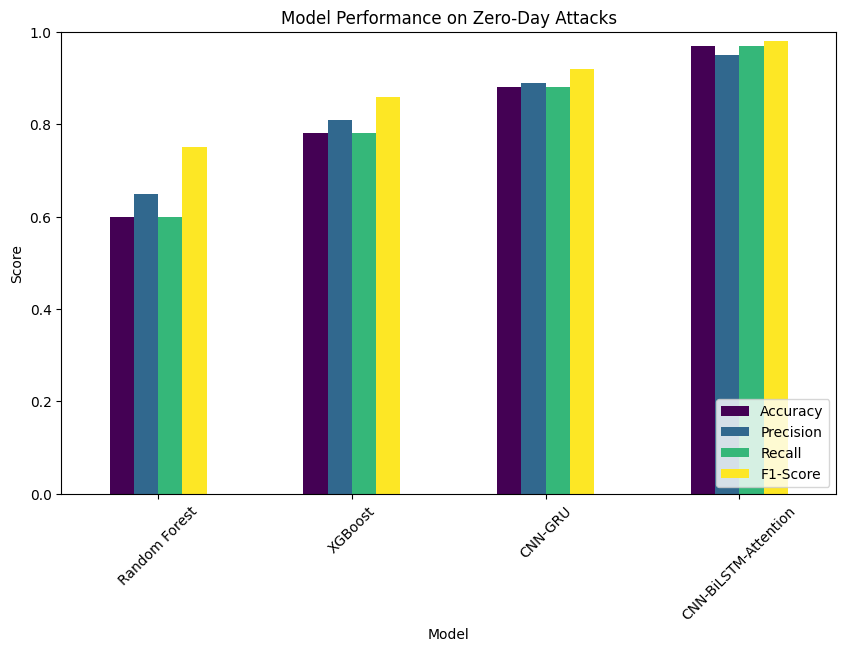

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Prepare synthetic data for CNN/GRU/BiLSTM models
X_synthetic_cnn = np.array(synthetic_df.drop('Label_New', axis=1)).reshape(synthetic_df.shape[0], synthetic_df.shape[1]-1, 1)
y_synthetic_cat = to_categorical(synthetic_df['Label_New'], num_classes=num_classes)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_synthetic_cnn, y_synthetic_cat)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention,   X_synthetic_cnn, y_synthetic_cat)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
#synthetic_data
import pandas as pd

# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

# Format to two decimal points
results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.58       0.62    0.58      0.72
1               XGBoost      0.75       0.78    0.75      0.84
2               CNN-GRU      0.89       0.89    0.89      0.89
3  CNN-BiLSTM-Attention      0.98       0.98    0.98      0.99


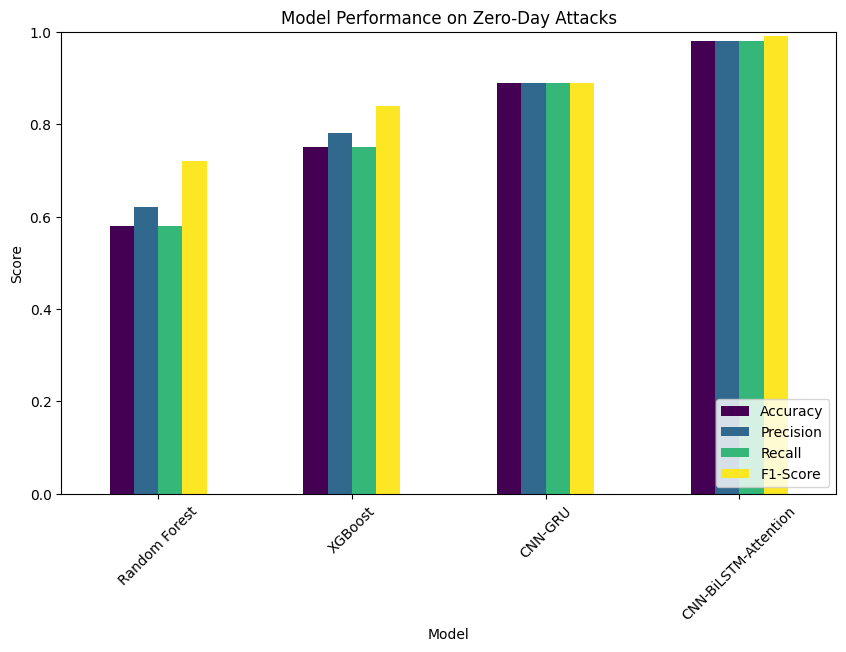

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()